In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
from fastcore.xtras import load_pickle

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])

import matplotx
import numpy as np
import pandas as pd

%matplotlib inline

In [48]:
all_res = glob("out/**/*.pkl")

In [49]:
compiled_res = []
compiled_gpr = []

for res in all_res:
    loaded = load_pickle(res)
    repre = loaded["representation"]
    num_points = loaded["num_train_points"]

    metrics = {
        "representation": loaded["representation"],
        "num_train_points": loaded["num_train_points"],
        "mae": loaded["mean_absolute_error"],
        "max_error": loaded["max_error"],
        "mse": loaded["mean_squared_error"],
    }

    compiled_res.append(metrics)

    gpr_metrics = {
        "num_train_points": loaded["num_train_points"],
        "mae": loaded["gpr_baseline"]["mean_absolute_error"],
        "max_error": loaded["gpr_baseline"]["max_error"],
        "mse": loaded["gpr_baseline"]["mean_squared_error"],
    }

    compiled_gpr.append(gpr_metrics)

In [50]:
compiled_res = pd.DataFrame(compiled_res)
compiled_gpr = pd.DataFrame(compiled_gpr)

In [51]:
compiled_grouped_res = compiled_res.groupby(["representation", "num_train_points"]).agg(
    ["mean", "std"]
)

In [52]:
compiled_gpr_grouped = compiled_gpr.groupby(["num_train_points"]).agg(["mean", "std"])

In [53]:
compiled_grouped_res

mae            max_error            \
                                     mean       std       mean       std   
representation num_train_points                                            
smiles         10                3.503780  0.325948  19.776667  3.964143   
               20                3.290752  0.339456  23.736000  0.766309   
               50                2.654048  0.106397  19.458000  1.657444   
               100               2.393213  0.575775  18.400000  1.831584   
               200               1.423840  0.077159  12.250000  1.736750   

                                       mse            
                                      mean       std  
representation num_train_points                       
smiles         10                20.410293  3.011757  
               20                19.598749  2.822821  
               50                13.417033  0.703130  
               100               11.726869  4.306574  
               200                4.590937  0.248249

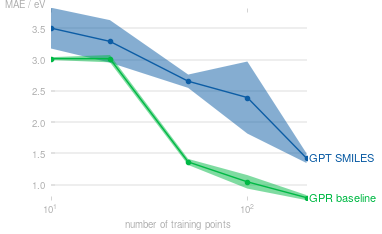

In [54]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(1, 1)
    # ax.plot(
    #     compiled_grouped_res.loc["SELFIES", :].index,
    #     compiled_grouped_res.loc["SELFIES", :]['mae']['mean'],
    #     label='GPT SELFIES',
    #     marker='o'
    # )

    # ax.fill_between(
    #     compiled_grouped_res.loc["SELFIES", :].index,
    #     compiled_grouped_res.loc["SELFIES", :]['mae']['mean'] - compiled_grouped_res.loc["SELFIES", :]['mae']['std'],
    #     compiled_grouped_res.loc["SELFIES", :]['mae']['mean'] + compiled_grouped_res.loc["SELFIES", :]['mae']['std'],
    # )

    ax.plot(
        compiled_grouped_res.loc["smiles", :].index,
        compiled_grouped_res.loc["smiles", :]["mae"]["mean"],
        label="GPT SMILES",
        marker="o",
    )

    ax.fill_between(
        compiled_grouped_res.loc["smiles", :].index,
        compiled_grouped_res.loc["smiles", :]["mae"]["mean"]
        - compiled_grouped_res.loc["smiles", :]["mae"]["std"],
        compiled_grouped_res.loc["smiles", :]["mae"]["mean"]
        + compiled_grouped_res.loc["smiles", :]["mae"]["std"],
        alpha=0.5,
    )

    ax.plot(
        compiled_gpr_grouped.loc[:].index,
        compiled_gpr_grouped["mae"]["mean"],
        label="GPR baseline",
        marker="o",
    )

    ax.fill_between(
        compiled_gpr_grouped.loc[:].index,
        compiled_gpr_grouped.loc[:]["mae"]["mean"] - compiled_gpr_grouped.loc[:]["mae"]["std"],
        compiled_gpr_grouped.loc[:]["mae"]["mean"] + compiled_gpr_grouped.loc[:]["mae"]["std"],
        alpha=0.5,
    )

    matplotx.line_labels(fontsize=8)

    ax.set_xlabel("number of training points", labelpad=4)
    matplotx.ylabel_top("MAE / eV")
    ax.set_xscale("log")

fig.savefig("freesolv_regression_res.pdf", bbox_inches="tight")